# SLT-CE-1: Locally Linear Embedding

Exercise to implement locally linear embedding ("An Introduction to Locally Linear Embedding" by Lawrence K. Saul) for dimension reduction. It embeds high-dimensional data while preserving the neighborhoods.


<h2 style="background-color:#f0b375;"> Setup </h2>

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as skl
import numpy as np
import scipy as sp
import scipy.sparse as sparse

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils.validation import check_is_fitted
from sklearn.neighbors import NearestNeighbors
from sklearn import manifold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from matplotlib.colors import ListedColormap

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [31]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<p style="background-color:#adebad;">
The MNIST data set contains three sets: **mnist.train, mnist.validation, mnist.test**  
Each of them is a numpy array with samples along rows, and pixels along columns.   
The original shape of the images is 28x28 = 784.
</p>

In [32]:
mnist.train.images.shape

(55000, 784)

In [33]:
mnist.validation.images.shape

(5000, 784)

In [34]:
mnist.test.images.shape

(10000, 784)

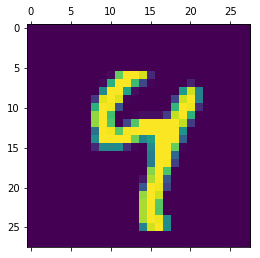

In [35]:
plt.matshow(mnist.train.images[2].reshape(28,28))
plt.show()

<h2 style="background-color:#f0b375;">
Problem 0  
<span style=font-size:50%> Complete all Problems to get the grade "1" </span>
</h2>

<p style="background-color:#adebad;">
    Shortly recapitulate the Locally Linear Embedding (LLE) algorithm, and the involved formulas.
</p>

1. Compute the neighbors of each data point Xi
2. Compute the weights Wij that best reconstruct each data point Xi from its neighbors, minimising the cost by constrained linear fits.
$$ \varepsilon (W)= \sum_i||\vec{X}_i-\sum_j W_{ij} \vec{X}_j||^2 $$
constrained by
$$ \sum_j W_{i,j}=1 \quad \text{and} \quad W_{i,j}=0 \quad\text{if not neighbors}$$
3. Compute the vectors Yi best reconstructed by the weights Wij, minimizing the quadratic form by its bottom nonzero eigenvectors
$$\Phi(Y)= \sum_i ||\vec{Y}_i- \sum_j W_{ij} \vec{Y}_j||^2 $$
subject to
$$ \sum_i \vec{Y}_i=0 \quad \text{and} \quad \sum_i \vec{Y}_i \vec{Y}_i^T= I_k$$

<h2 style="background-color:#f0b375;"> Problem 1 </h2>

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
</p>

In [91]:
class LocallyLinearEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for LLE, compare to `sklearn LLE`_.
    
    Attributes:
        embedding_vectors_ (np.ndarray): Embedding of input X with shape (samples, n_components)
        nbrs_X (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for training set X.
        nbrs_y (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for embedding_vectors_.
        M_ (np.array): Symmetric matrix (samples, samples), used in quadratic form for embedding.
        X_ (np.array): Copy of training set with shape (samples, dim).
    
       .. _`sklearn LLE`: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html
    """
    
    def __init__(self, n_neighbors=10, n_components=2):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
    
    def fit(self, X):
        """Compute LLE embedding of vectors X
        
        First, compute nbrs_X and M_.
        Finally, compute embedding_vectors_.
        
        Args:
            X (np.ndarray): Input array with shape (samples, dim)
        
        Returns:
            self
        """       
        
        self.nbrs_X= NearestNeighbors(self.n_neighbors+1, algorithm='kd_tree').fit(X)
        self.X_= X;
        self.embedding_vectors_= np.empty((X.shape[0], 0))
        
        distances, indices = self.nbrs_X.kneighbors(X)
        
        self.M_= np.zeros((X.shape[0], X.shape[0]))
        W= np.zeros((X.shape[0], X.shape[0]))

        for i in range(0, X.shape[0]):
            # extract nearest neighbours of current data point
            Z= np.array(X[indices[i, 1:], :])

            # subtract Xi from all nearest neighbours
            for k in range(0, Z.shape[0]):
                Z[k, :]= Z[k, :]- X[i, :]

            # calculate local covariance    
            C= np.dot(Z, Z.T)
            w= np.linalg.solve(C, np.ones((C.shape[0], 1)))
            w= w/ np.sum(w)

            # set Wij
            # check here XXX need to define it before?
            W[i, indices[i, 1:]]= w.T
            
        # create sparse matrix    
        self.M_= np.dot((np.identity(W.shape[0])- W).T , np.identity(W.shape[0])- W)

        # calculate eigenvalues and eigenvectors
        eigw, eigv= sp.linalg.eigh(self.M_, eigvals= (0, self.n_components))

        # use bottom d+1 eigenvectors of M -> set qth row of Y to be q+1 smallest eigenvector
        # note 1: bottom eigenvectors -> eigenvectors with smallest eigenvalue
        # note 2: neglect bottom eigenvector with zero eigenvalue
        
        for i in range(1, self.n_components+1):
            v_append= eigv[:, eigw.argsort()[i]].reshape(-1, 1)
            # .reshape(self.n_components, 1)
            self.embedding_vectors_= np.append(self.embedding_vectors_, v_append, axis= 1)
        
        # store nearest neighbors in embedding space
        self.nbrs_y= NearestNeighbors(self.n_neighbors+1, algorithm='kd_tree').fit(self.embedding_vectors_)
        
        return self
        
    
    def transform(self, X):
        """Map new vectors X to embedding space
        
        Use the fitted model to map new vectors to the space with dimension n_components.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, dim)
            
        Returns:
            y (np.ndarray): Embedded vectors with shape (new_samples, n_components)
        """
                       
        check_is_fitted(self, ["embedding_vectors_", "nbrs_X"])
        
        # calculate nearest neighbors of matrix X in basis self.X_
        nbrs= self.nbrs_X.kneighbors(X, n_neighbors=self.n_neighbors+1, return_distance=False)
        
        # calculate weight matrix
        W= np.zeros((X.shape[0], self.n_neighbors))

        for i in range(0, X.shape[0]):
            # extract nearest neighbours of current data point
            Z= np.array(self.X_[nbrs[i, 1:], :])

            # subtract Xi from all nearest neighbours
            for k in range(0, Z.shape[0]):
                Z[k, :]= Z[k, :]- X[i, :]

            # calculate local covariance    
            C= np.dot(Z, Z.T)
            
            # set Wij
            w= np.linalg.solve(C, np.ones((C.shape[0], 1)))    
            w= w/ np.sum(w)

            W[i]= w.T
        
        # calculate embedding
        y = np.empty((X.shape[0], self.n_components))
        
        for i in range (X.shape[0]):
            y[i] = np.dot(W[i: i+1], self.embedding_vectors_[nbrs[i, 1:]])
            
        return y

    def inverse_transform(self, y):
        """Map new vectors y to input space with dimension dim.
        
        Use the fitted model to map vectors y to the original input space.
        
        Args:
            y (np.ndarray): Input array with shape (new_samples, n_components)
            
        Returns:
            X (np.ndarray): Vectors with shape (new_samples, dim)
        """
        
        check_is_fitted(self, ["embedding_vectors_", "X_", "nbrs_y"])
        
        # find nearest neighbors of y in nbrs_y
        nbrs= self.nbrs_y.kneighbors(y, n_neighbors=self.n_neighbors+1, return_distance=False)
        
        # calculate weight matrix
        W= np.zeros((y.shape[0], self.n_neighbors))

        for i in range(0, y.shape[0]):
            # extract nearest neighbours of current data point
            Z= np.array(self.embedding_vectors_[nbrs[i, 1:], :])

            # subtract yi from all nearest neighbours
            for k in range(0, Z.shape[0]):
                Z[k, :]= Z[k, :]- y[i, :]

            # calculate local covariance    
            C= np.dot(Z, Z.T)
            w= np.linalg.solve(C, np.ones((C.shape[0], 1)))
            w= w/ np.sum(w)

            # set Wij
            W[i]= w.T
        
        # calculate reconstruction
        X = np.empty((y.shape[0], self.X_.shape[1]))
        
        for i in range (y.shape[0]):
            X[i] = np.dot(W[i: i+1], self.X_[nbrs[i, 1:]])
            
        return X


<p style="background-color:#adebad;">
    Create an instance of your LLE class with default parameters and fit the MNIST validation set. Record the execution time (should be about 30 sec). Furthermore, create an instance of the sklearn LLE class, and fit it with the same parameters. Again record the execution time.  
    Note, the dots should be filled in by you.
</p>

(5000, 784)


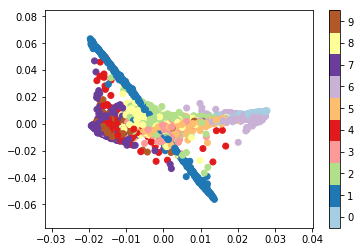

CPU times: user 2min 42s, sys: 12.8 s, total: 2min 55s
Wall time: 46.4 s


In [92]:
%%time
myLLE = LocallyLinearEmbedding()
print(mnist.validation.images.shape)
myLLE.fit(mnist.validation.images)

plt.figure()
paired= plt.get_cmap('Paired', 10)
plt.scatter(myLLE.embedding_vectors_[:, 0], myLLE.embedding_vectors_[:, 1], c=mnist.validation.labels, cmap= paired)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);
plt.show()

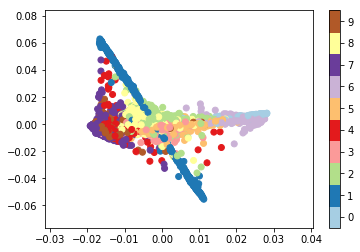

CPU times: user 1min 47s, sys: 58.1 s, total: 2min 45s
Wall time: 43.3 s


In [97]:
%%time
sklLLE = skl.manifold.LocallyLinearEmbedding(random_state=42, n_neighbors=10)
sklLLE.fit(mnist.validation.images)

plt.figure()
paired= plt.get_cmap('Paired', 10)
plt.scatter(sklLLE.embedding_[:, 0], sklLLE.embedding_[:, 1], c=mnist.validation.labels, cmap= paired)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);
plt.show()

<p style="background-color:#adebad;">
    Plot myLLE.embedding\_vectors\_ and sklLLE.embedding\_vectors\_ in two separate plots.
</p>

The embeddings of the implemented LLE class and the skl LLE class show very good agreement

<h2 style="background-color:#f0b375;"> Problem 2 </h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        
        <li>Use myLLE.transform and sklLLE.transform to map the <b>MNIST test set</b> to the LLE embedding space (Maybe you have to repeat the instantiation and fitting before you can transform). sklLLE takes about 50 sec.
        </li>
        
        <li>
            Plot both embeddings in two separate plots for comparison.
        </li>
    </ul>
</p>

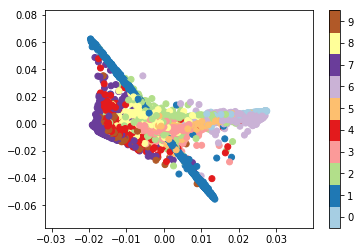

CPU times: user 1min 6s, sys: 356 ms, total: 1min 6s
Wall time: 1min 5s


In [93]:
%%time
my_embedding = myLLE.transform(mnist.test.images)

plt.figure()
paired= plt.get_cmap('Paired', 10)
plt.scatter(my_embedding[:, 0], my_embedding[:, 1], c=mnist.test.labels, cmap= paired)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);
plt.show()

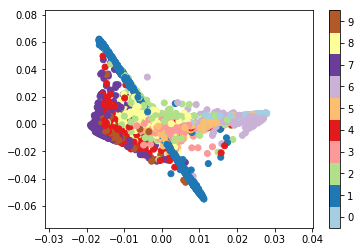

CPU times: user 1min 14s, sys: 406 ms, total: 1min 15s
Wall time: 1min 14s


In [98]:
%%time
skl_embedding = sklLLE.transform(mnist.test.images)

plt.figure()
paired= plt.get_cmap('Paired', 10)
plt.scatter(skl_embedding[:, 0], skl_embedding[:, 1], c=mnist.test.labels, cmap= paired)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);
plt.show()

Comparing the embedding of the test set with the implemented LLE class and the skl LLE class shows again very good agreement.

<h2 style="background-color:#f0b375;"> Problem 3 </h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>inverse_transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        <li>
        Use myLLE.transform and myLLE.inverse_transform to embed the first digit of the MNIST training set and then recover it. 
        </li>
       
    </ul>

In [94]:
# embedd and reconstruct #0
embedded_digit1 = myLLE.transform(mnist.train.images[7].reshape(1, -1))
reconstructed_digit1 = myLLE.inverse_transform(embedded_digit1)

# embed and reconstruct #3
embedded_digit2 = myLLE.transform(mnist.train.images[1].reshape(1, -1))
reconstructed_digit2 = myLLE.inverse_transform(embedded_digit2)

<ul style="background-color:#adebad;">
        <li>
        Plot the original digit and the reconstructed digit for comparison.
        </li>
    </ul>

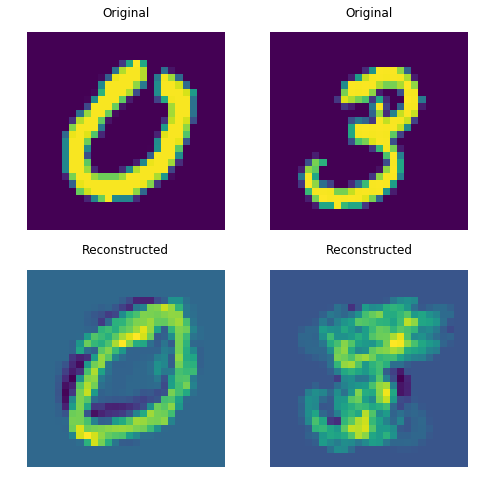

In [95]:
fig, ax= plt.subplots(2, 2, figsize=(8,8))
#0 original
ax[0, 0].matshow(mnist.train.images[7].reshape(28,28))
ax[0, 0].set_title("Original")
ax[0, 0].axis('off')

#0 reconstruction
ax[1, 0].matshow(reconstructed_digit1.reshape(28,28))
ax[1, 0].set_title("Reconstructed")
ax[1, 0].axis('off')

#3 original
ax[0, 1].matshow(mnist.train.images[1].reshape(28,28))
ax[0, 1].set_title("Original")
ax[0, 1].axis('off')

#0 reconstruction
ax[1, 1].matshow(reconstructed_digit2.reshape(28,28))
ax[1, 1].set_title("Reconstructed")
ax[1,1 ].axis('off')
fig.show()

The reconstruction for two different digites (0 and 3) is plotted. For digit 0, the reconstruction works
pretty well because its embeddings are clustered closely together such that the neighbors used for the embedding and reconstruction are very likely zeros.
For digit 3, the reconstruction works less well because its embeddings are less clustered but are mixed with embeddings of digit 8. Therefore, some of the neighbors are likely eights, which leads to the plotted figure.

<h2 style="background-color:#f0b375;"> Problem 4 </h2>

<ul style="background-color:#adebad;">
        <li>
        Perform more experiments (embeddings, reconstructions) with different parameters (e.g. n_neighbors, n_components).  
        Describe and plot the results. Make sure that it is clear what the reason of your experiments is, and what the outcome is.
        </li>
    </ul>

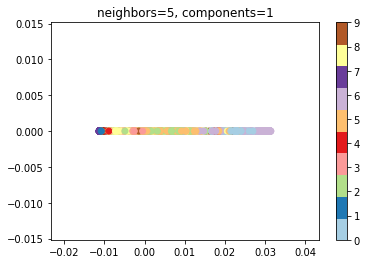

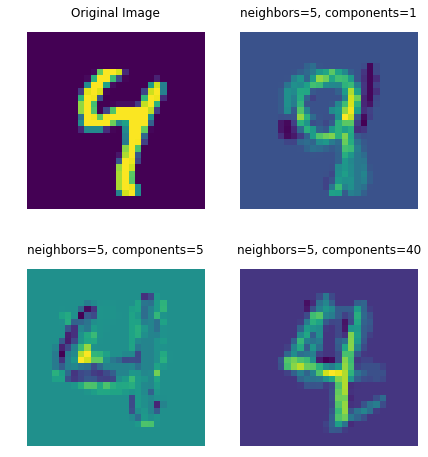

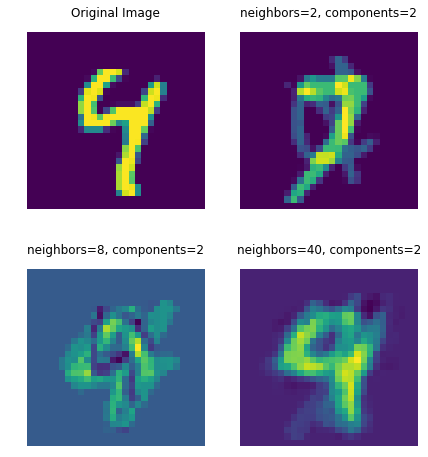

In [102]:
## [Fault] The experiments only analyze what happens when 
##the number of components is fixed and the 
##number of neighbors is varied and vice versa. 
##However, there is no analysis on what happens 
##when both are varied. In particular, there is 
##not a recommendation on the best values 
##for these two variables.


# Vary dimensions (components) --------------------------------------------------------------------
# locally linear embedding with reduced dimension (n_components=1)
myLLE_lower_dim = LocallyLinearEmbedding(n_neighbors= 5, n_components= 1)
myLLE_lower_dim.fit(mnist.validation.images)
em_digit_lower_dim = myLLE_lower_dim.transform(mnist.train.images[2].reshape(1, -1))
recon_digit_lower_dim = myLLE_lower_dim.inverse_transform(em_digit_lower_dim)

plt.figure()
paired= plt.get_cmap('Paired', 10)
plt.scatter(myLLE_lower_dim.embedding_vectors_[:, 0], np.zeros([myLLE_lower_dim.embedding_vectors_.shape[0], 1]),  c=mnist.validation.labels, cmap= paired)
plt.title("neighbors=5, components=1")
plt.colorbar(ticks=range(10))
plt.show()

# locally linear embedding with increased dimension (n_components=5)
myLLE_higher_dim1 = LocallyLinearEmbedding(n_neighbors= 5, n_components= 5)
myLLE_higher_dim1.fit(mnist.validation.images)
em_digit_higher_dim1 = myLLE_higher_dim1.transform(mnist.train.images[2].reshape(1, -1))
recon_digit_higher_dim1 = myLLE_higher_dim1.inverse_transform(em_digit_higher_dim1)

# locally linear embedding with increased dimension (n_components=40)
myLLE_higher_dim2 = LocallyLinearEmbedding(n_neighbors= 5, n_components= 40)
myLLE_higher_dim2.fit(mnist.validation.images)
em_digit_higher_dim2 = myLLE_higher_dim2.transform(mnist.train.images[2].reshape(1, -1))
recon_digit_higher_dim2 =myLLE_higher_dim2.inverse_transform(em_digit_higher_dim2)

# Vary neighbours ---------------------------------------------------------------------------------
# locally linear embedding with less neighbors (n_neighbors=2)
myLLE_less_neigh = LocallyLinearEmbedding(n_neighbors= 2, n_components= 2)
myLLE_less_neigh.fit(mnist.validation.images)
em_digit_less_neigh = myLLE_less_neigh.transform(mnist.train.images[2].reshape(1, -1))
recon_digit_less_neigh = myLLE_less_neigh.inverse_transform(em_digit_less_neigh)

# locally linear embedding with more neighbors (n_neighbors=8)
myLLE_more_neigh1 = LocallyLinearEmbedding(n_neighbors= 8, n_components= 2)
myLLE_more_neigh1.fit(mnist.validation.images)
em_digit_more_neigh1 = myLLE_more_neigh1.transform(mnist.train.images[2].reshape(1, -1))
recon_digit_more_neigh1 = myLLE_more_neigh1.inverse_transform(em_digit_more_neigh1)


# locally linear embedding with more neighbors (n_neighbors=40)
myLLE_more_neigh2 = LocallyLinearEmbedding(n_neighbors= 40, n_components= 2)
myLLE_more_neigh2.fit(mnist.validation.images)
em_digit_more_neigh2 = myLLE_more_neigh2.transform(mnist.train.images[2].reshape(1, -1))
recon_digit_more_neigh2 = myLLE_more_neigh2.inverse_transform(em_digit_more_neigh2)

# Plot results --------------------------------------------------------------------------------------
# Vary number of components (dimensions)
fig, ax= plt.subplots(2, 2, figsize=(7,8))
ax[0,0].matshow(mnist.train.images[2].reshape(28,28))
ax[0,0].set_title("Original Image")

ax[0,1].matshow(recon_digit_lower_dim.reshape(28,28))
ax[0,1].set_title("neighbors=5, components=1")

ax[1,0].matshow(recon_digit_higher_dim1.reshape(28,28))
ax[1,0].set_title("neighbors=5, components=5")

ax[1,1].matshow(recon_digit_higher_dim2.reshape(28,28))
ax[1,1].set_title("neighbors=5, components=40")

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
fig.show()

# Vary number of neighbours
fig, ax= plt.subplots(2, 2, figsize=(7,8))
ax[0,0].matshow(mnist.train.images[2].reshape(28,28))
ax[0,0].set_title("Original Image")

ax[0,1].matshow(recon_digit_less_neigh.reshape(28,28))
ax[0,1].set_title("neighbors=2, components=2")

ax[1,0].matshow(recon_digit_more_neigh1.reshape(28,28))
ax[1,0].set_title("neighbors=8, components=2")

ax[1,1].matshow(recon_digit_more_neigh2.reshape(28,28))
ax[1,1].set_title("neighbors=40, components=2")

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
fig.show()

As suggested, there are two main parameters to vary namely the number of components (dimensions of embedding) and the number of neighbors.

In a first step, the influence of the number of components is investigated: If the number of components is decreased, the embedding & reconstruction becomes less reliable. This is a consequence of the reduced number of features that can be captured and hence maps the digits closer together (see the plot of the embedding space for just 1 component). As a result, it is more likely that among the neighbors there are other digits leading to a worse reconstruction. Contrarily, increasing the number of components has a positive influence since more features are captured and the different digits are further apart in the higher dimensional embedding space.

In a second step, the influence of the number of neighbors is investigated: In this case, a trade-off is observed. If the number of neighbors is largely increased, neighbors from further away will enter into the reconstruction process. It is therefore more likely that also other digits are used for the embedding & reconstruction leading to a blurring out of the original digit. On the other side, if only a few neighbors are used, there is a chance that exactly the same digit is the nearest neighbor in the embedding space. Hence the reconstruction works well. However, there is also the possibility that the nearest neighbor is a different digit, leading to a miss-reconstruction. A number of neighbors around 5-10 seems to be reasonable.

<h2 style="background-color:#ef7575;">
Extension 1  
<span style=font-size:50%> Complete two Extensions to get the grade "2" </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Plot the linear interpolation between two digits in the input space compared to the reconstruction along the linear interpolation of their embeddings.
        </li>
    </ul>

LinAlgError: Singular matrix

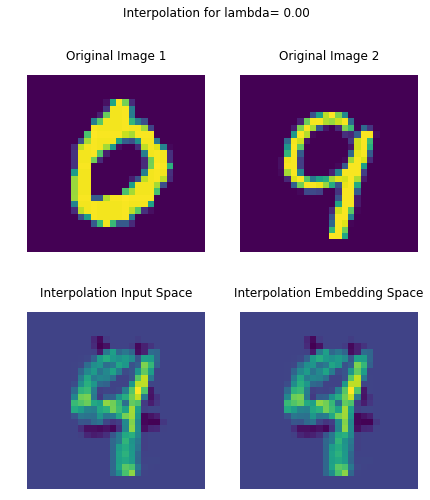

In [103]:
# interpolation parameter i.e. lam* digit1 1 (1- lam)* digit2
lam= np.arange(0.0, 1.1, 0.1)

# image selection
im1= mnist.test.images[3]
im2= mnist.test.images[16]

# transformation of two digits into embedding space
embedding2 = myLLE.transform(im1.reshape(1, -1))
embedding3 = myLLE.transform(im2.reshape(1, -1))

for i in range(0, 11):
    # interpolation in input space ----------------------------------------------------
    input_interpol= np.dot(lam[i], im1)+  np.dot((1-lam[i]), im2)
    
    # transformation
    em_input_interpol = myLLE.transform(input_interpol.reshape(1, -1))
    
    # reconstruction
    recon_input_interpol = myLLE.inverse_transform(em_input_interpol)
  
    # interpolation in embedding space -------------------------------------------------
    em_embedding_interpol = np.dot(lam[i], embedding2)+ np.dot((1-lam[i]), embedding3)
       
    # reconstruction
    recon_embedding_interpol =myLLE.inverse_transform(em_embedding_interpol)

    # plot ------------------------------------------------------------------------------
    fig, ax= plt.subplots(2, 2, figsize=(7,8))
    ax[0, 0].matshow(im1.reshape(28,28))
    ax[0, 0].set_title("Original Image 1")

    ax[0, 1].matshow(im2.reshape(28,28))
    ax[0, 1].set_title("Original Image 2")

    ax[1, 0].matshow(recon_input_interpol.reshape(28,28))
    ax[1, 0].set_title("Interpolation Input Space")

    ax[1, 1].matshow(recon_embedding_interpol.reshape(28,28))
    ax[1, 1].set_title("Interpolation Embedding Space")

    ax[0, 0].axis('off')
    ax[0, 1].axis('off')
    ax[1, 0].axis('off')
    ax[1, 1].axis('off')
    fig.suptitle('Interpolation for lambda= '+ str("{0:.2f}".format(round(lam[i],2))))
    fig.show()

Check: for either lam=0 or lam=1 the reconstruction look the same for the interpolation in the input space and the interpolation in the embedding space. Furthermore, it is very likely that they represent Original Image 1 for lam=1 or Original Image 2 for lam=0.

For lam close to 0 or 1, the two interpolations look very similar but start to deviate from the respective original image.

For lam close to 0.5 they can look very different to the original image and also very different to each other.

<ul style="background-color:#adebad;">
        <li>
        Select an image of a digit "6" and a digit "8".  
        Rotate both input images by 360° in steps of 1° and create the embedding of each rotation.  
        Plot the corresponding reconstructions, and the respective path in the 2D embedding space.  
        </li>
    </ul>

LinAlgError: Singular matrix

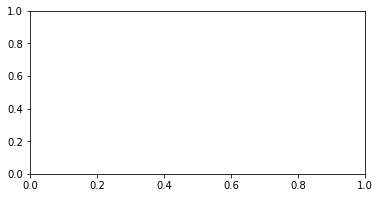

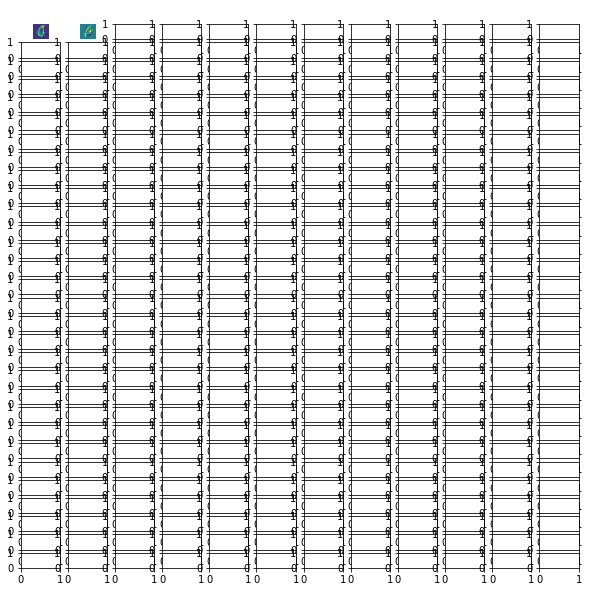

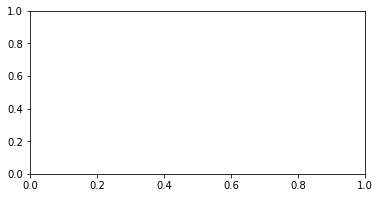

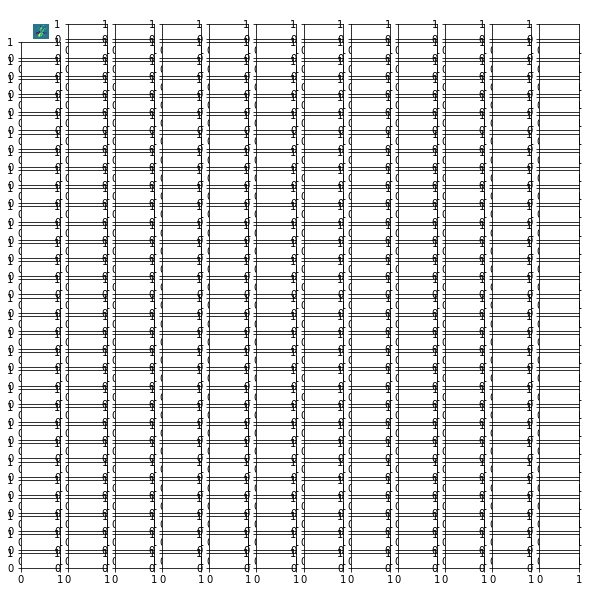

In [105]:
# #6
im6 = mnist.test.images[11]
im6_em= np.empty([360, 2])

# #8
im8 = mnist.test.images[61]
im8_em= np.empty([360, 2])

# Figures to plot #6: rotation only; rotation and LLE; reconstruction of rotation
# fig_rot_6, ax_rot_6= plt.subplots(30, 12, figsize=(10,10))
fig_em_6, ax_em_6= plt.subplots(1, 1, figsize=(6,3))
fig_re_6, ax_re_6= plt.subplots(30, 12, figsize=(10,10))

# Figures to plot #8: rotation only; rotation and LLE; reconstruction of rotation
# fig_rot_8, ax_rot_8= plt.subplots(30, 12, figsize=(10,10))
fig_em_8, ax_em_8= plt.subplots(1, 1, figsize=(6,3))
fig_re_8, ax_re_8= plt.subplots(30, 12, figsize=(10,10))

# color style for plot
ccmap=  plt.get_cmap('YlOrRd', 360)

# splitting rotation into two loops for convenient plotting
for i in range(0, 30):
    for k in range(0, 12):
        # operations for #6 --------------------------------------------------------------
        # rotation
        rot_mat_6= sp.ndimage.interpolation.rotate(im6.reshape(28,28), angle=k+ i*12, axes=(1, 0), reshape= False)
        
        # LLE transform
        rot_mat_em_6= myLLE.transform(rot_mat_6.reshape(1, 784))
        im6_em[k+ i*12, :]= rot_mat_em_6
        
        # Reconstruction
        rot_mat_recon_6= myLLE.inverse_transform(rot_mat_em_6)
        
        # preparation of plots
        # ax_rot_6[i, k].matshow(rot_mat_6)
        # ax_rot_6[i, k].axis('off')
        
        ax_re_6[i, k].matshow(rot_mat_recon_6.reshape(28, 28))
        ax_re_6[i, k].axis('off')
        
        # operations for #8 --------------------------------------------------------------
        # rotation
        rot_mat_8= sp.ndimage.interpolation.rotate(im8.reshape(28,28), angle=k+ i*12, axes=(1, 0), reshape= False)
        
        # LLE transform
        rot_mat_em_8= myLLE.transform(rot_mat_8.reshape(1, 784))
        im8_em[k+ i*12, :]= rot_mat_em_8
        
        # Reconstruction
        rot_mat_recon_8= myLLE.inverse_transform(rot_mat_em_8)
        
        # preparation of plots
        # ax_rot_8[i, k].matshow(rot_mat_8)
        # ax_rot_8[i, k].axis('off')

        ax_re_8[i, k].matshow(rot_mat_recon_8.reshape(28, 28))
        ax_re_8[i, k].axis('off')
 
# fig_rot_6.suptitle("Rotation of Original Image (#6)")
# fig_rot_6.show()

ax_em_6.scatter(im6_em[:, 0], im6_em[:, 1], cmap= ccmap)
fig_em_6.suptitle("Embedding (#6)")
fig_em_6.show()

fig_re_6.suptitle("Rotation of Reconstructed Image (#6)")
fig_re_6.show()

# fig_rot_8.suptitle("Rotation of Original Image (#8)")
# fig_rot_8.show()

ax_em_8.scatter(im8_em[:, 0], im8_em[:, 1], cmap= ccmap)
fig_em_8.suptitle("Embedding (#8)")
fig_em_8.show()

fig_re_8.suptitle("Rotation of Reconstructed Image (#8)")
fig_re_8.show()

## [Fault] The graph does not illustrate the path defined by the embeddings of the rotations.

It is observed that while rotating the image, the digit is mapped to very different regions in the embedding space and hence the reconstrution varies heavily, not anymore able to find the original digit.

This is because the embedding vectors were constructed for upright figures, thus not allowing to recognize the figure under different rotational angles.

<h2 style="background-color:#ef7575;"> Extension 2 </h2>

<ul style="background-color:#adebad;">
        <li>
        Create a matrix plot of the matrix M\_.  
        Make sure to permute the rows and columns according to the digit labels, so that you can actually observe the block structure.
        </li>
        <li>
        Plot the spectrum (eigenvalues) of M\_. Can you identify a good cutoff? What could you use the value of the cutoff for?
        </li>
    </ul>

<h2 style="background-color:#ef7575;"> Extension 3 </h2>

<ul style="background-color:#adebad;">
        <li>
        Train a multilayer perceptron with two hidden layers (some width between 1000-3000) on the MNIST training set (e.g. sklearn.neural_network.MLPClassifier).
        </li>
    </ul>

In [ ]:
%%time
from sklearn.preprocessing import StandardScaler

# normalization of data for better convergence
scaler = StandardScaler()
scaler.fit(mnist.train.images)
X_train = scaler.transform(mnist.train.images)

y_train= mnist.train.labels

# initialize and train MLP
clf = MLPClassifier(hidden_layer_sizes=(1000, 1000), max_iter= 200)
clf.fit(X_train, y_train)

<ul style="background-color:#adebad;">
        <li>
        "Embed" the MNIST validation set and the first 5000 MNIST training samples with the trained MLP.  
        To do so, use the coefs_ of the MLP to map the input digits to the first and second hidden layer.  
        In total, you should have four "embeddings": mnist_valid_1st_hidden, mnist_valid_2nd_hidden, mnist_train_1st_hidden and mnist_train_2nd_hidden.
        </li>
    </ul>

In [ ]:
def relu_activation(data_array):
    return np.maximum(data_array, 0)

# perform multiplication by weights and apply activation for validation set
mnist_valid_1st_hidden= relu_activation(np.dot(mnist.validation.images, clf.coefs_[0]))
mnist_valid_2nd_hidden= relu_activation(np.dot(mnist_valid_1st_hidden, clf.coefs_[1]))

# perform multiplication by weights and apply activation for training set
mnist_train_1st_hidden= relu_activation(np.dot(mnist.train.images[:5000], clf.coefs_[0]))
mnist_train_2nd_hidden= relu_activation(np.dot(mnist_train_1st_hidden, clf.coefs_[1]))

<ul style="background-color:#adebad;">
        <li>
        Use LLE to embed the "embeddings" and investigate how the embedding structure changes from raw input -> first hidden layer -> second hidden layer.
        </li>
    </ul>

In [ ]:
# Validation set --------------------------------------------------------------------------------
# LLE for validation set and 1st hidden layer
LLE_valid_1st_hidden = skl.manifold.LocallyLinearEmbedding(random_state=42)
LLE_valid_1st_hidden.fit(mnist_valid_1st_hidden)

# LLE for validation set and 1st hidden layer
LLE_valid_2nd_hidden = skl.manifold.LocallyLinearEmbedding(random_state=42)
LLE_valid_2nd_hidden.fit(mnist_valid_2nd_hidden)

# Training set -----------------------------------------------------------------------------------
# LLE for training set and 1st hidden layer
LLE_train_raw = skl.manifold.LocallyLinearEmbedding(random_state=42)
LLE_train_raw.fit(mnist.train.images[:5000])

# LLE for training set and 1st hidden layer
LLE_train_1st_hidden = skl.manifold.LocallyLinearEmbedding(random_state=42)
LLE_train_1st_hidden.fit(mnist_train_1st_hidden)

# LLE for training set and 1st hidden layer
LLE_train_2nd_hidden = skl.manifold.LocallyLinearEmbedding(random_state=42)
LLE_train_2nd_hidden.fit(mnist_train_2nd_hidden)

# Figure Validation set ---------------------------------------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=(14,3))
paired= plt.get_cmap('Paired', 10)
# raw embedding
ax[0].scatter(sklLLE.embedding_[:, 0], sklLLE.embedding_[:, 1], c=mnist.validation.labels, cmap= paired)
ax[0].set_title("Raw Embedding")

# first hidden layer embedding
ax[1].scatter(LLE_valid_1st_hidden.embedding_[:, 0], LLE_valid_1st_hidden.embedding_[:, 1], c=mnist.validation.labels, cmap= paired)
ax[1].set_title("First Hidden Layer Embedding")

# second hidden layer embedding
c_plot= ax[2].scatter(LLE_valid_2nd_hidden.embedding_[:, 0], LLE_valid_2nd_hidden.embedding_[:, 1], c=mnist.validation.labels, cmap= paired)
ax[2].set_title("Second Hidden Layer Embedding")

cbar= fig.colorbar(c_plot, ax=ax[2], ticks=range(10))
cbar.set_clim(-0.5, 9.5);
fig.suptitle("Validation Set")
fig.show()

# Figure Training set -----------------------------------------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=(14,3))
paired= plt.get_cmap('Paired', 10)
# raw embedding
ax[0].scatter(LLE_train_raw.embedding_[:, 0], LLE_train_raw.embedding_[:, 1], c=mnist.train.labels[:5000], cmap= paired)
ax[0].set_title("Raw Embedding")

# first hidden layer embedding
ax[1].scatter(LLE_train_1st_hidden.embedding_[:, 0], LLE_train_1st_hidden.embedding_[:, 1], c=mnist.train.labels[:5000], cmap= paired)
ax[1].set_title("First Hidden Layer Embedding")

# second hidden layer embedding
c_plot= ax[2].scatter(LLE_train_2nd_hidden.embedding_[:, 0], LLE_train_2nd_hidden.embedding_[:, 1], c=mnist.train.labels[:5000], cmap= paired)
ax[2].set_title("Second Hidden Layer Embedding")

cbar= fig.colorbar(c_plot, ax=ax[2], ticks=range(10))
cbar.set_clim(-0.5, 9.5);
fig.suptitle("Training Set")
fig.show()

Note: the embedding was calculated for each set and each output (i.e. raw, first hidden, second hidden) seperately.
Note 2: 1000 hidden units are used for each layer -> dimension of digits gets transformed from 768 -> 1000

The shape of embedding of the first hidden layer looks quite different between the two sets.

There are some similarities between the shapes of the embeddings of the outputs of the second hidden layer, however, the rotation of the shape changes. Some number (e.g. 1, 5) are mapped to a similar location (in this case a corner of the shape). Other appear at a different location (e.g. 7)



<ul style="background-color:#adebad;">
        <li>
        Repeat the experiment, but this time with an autoencoder (e.g. sklearn.neural_network.MLPRegressor with fit(X,X)).  
        The hidden layers should be 200-500 units wide.  
        Not necessary for completion of Extension 3.
        </li>
    </ul>